In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
import cv2

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
from model import VAE

set_random_seed(seed=0)

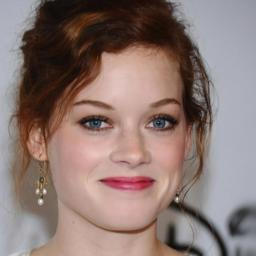

In [2]:
img = Image.open(f"data/celeba_hq_256/00555.jpg")
img

In [4]:
def load_images_from_folder(folder_path: str) -> np.ndarray:
    images = []
    # cnt = 0 
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        img_array = cv2.resize(img_array, (128,128), interpolation=cv2.INTER_CUBIC) 
        images.append(img_array)
        # cnt += 1
        # if cnt == 10_000:
        #     break
    return np.array(images)

celeba_raw = load_images_from_folder(folder_path="data/celeba_hq_256")

celeba = (celeba_raw / 255 - 0.5) / 0.5
celeba = torch.tensor(celeba, dtype=torch.float32)
celeba = celeba.permute(0,3,1,2)

celeba.shape

 33%|███▎      | 9999/30000 [00:17<00:35, 560.01it/s]


torch.Size([10000, 3, 128, 128])

In [12]:
class CelebaDataset(Dataset):
    def __init__(self, data: np.ndarray) -> None:
        self.data = data

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]
    
    def __len__(self) -> int:
        return len(self.data)

In [14]:
dataset = CelebaDataset(data=celeba)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

dataset.__getitem__(0)

tensor([[[ 0.9059,  0.9059,  0.9059,  ...,  0.9059,  0.9059,  0.9059],
         [ 0.9059,  0.9059,  0.9059,  ...,  0.9137,  0.9137,  0.9137],
         [ 0.9059,  0.9059,  0.9059,  ...,  0.9137,  0.9137,  0.9137],
         ...,
         [ 0.2000,  0.2941,  0.3098,  ...,  0.9529,  0.9529,  0.9529],
         [-0.0588,  0.0745,  0.2157,  ...,  0.9529,  0.9529,  0.9529],
         [-0.2078, -0.2863, -0.1216,  ...,  0.9529,  0.9529,  0.9529]],

        [[ 0.9059,  0.9059,  0.9059,  ...,  0.8980,  0.8980,  0.8980],
         [ 0.9059,  0.9059,  0.9059,  ...,  0.8980,  0.8980,  0.8980],
         [ 0.9059,  0.9059,  0.9059,  ...,  0.9137,  0.9137,  0.9137],
         ...,
         [ 0.1843,  0.2784,  0.2941,  ...,  0.9529,  0.9529,  0.9529],
         [-0.0745,  0.0588,  0.2000,  ...,  0.9529,  0.9529,  0.9529],
         [-0.2314, -0.3020, -0.1373,  ...,  0.9529,  0.9529,  0.9529]],

        [[ 0.9216,  0.9216,  0.9216,  ...,  0.9373,  0.9373,  0.9373],
         [ 0.9216,  0.9216,  0.9216,  ...,  0

In [ ]:
epochs = 20
latent_dim = 512

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, x in enumerate(dataloader):
        
        x = x.to(device)
        x_hat, mu, log_sd = model(x)
        
        reconstruction_loss = model.reconstruction_loss(x=x, x_hat=x_hat)
        kl_divergence = model.kl_divergence(mu=mu, sd=torch.exp(log_sd))
        total_loss = reconstruction_loss + kl_divergence
        
        optimizer.zero_grad()
        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=50)
        optimizer.step()
        
        if batch % 50 == 0:
            print(
                f"epoch={epoch}",
                f"batch={batch:03d}",
                f"mse={reconstruction_loss.item():.3f}",
                f"kl={kl_divergence.item():.3f}",
                f"total_loss={total_loss.item():.3f}"
            )
    print()

In [ ]:
for i in range(10):

    ex = x[i].detach().cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    ax1.imshow(ex.permute(1,2,0));

    ex_inp = ex.unsqueeze(0)
    ex_inp_hat, _, _ = model(ex_inp.to(device))
    ax2.imshow(ex_inp_hat.view(3,128,128).permute(1,2,0).cpu().detach().numpy());
    plt.show()

# Transition

In [ ]:
randints = random.sample(range(30_000), 10)
imgs = [celeba[r] for r in randints]

In [ ]:
params = []
for img in imgs:
    
    img_inp = img.unsqueeze(0)
    img_inp = img_inp.to(device)
    
    mu, log_sd = model.encoder(img_inp)
    params.append((mu, log_sd))

In [ ]:
eps = torch.randn_like(mu)

STEPS = 20

decoded = []
for i in range(len(params) - 1):
    mu_prev, log_sd_prev = params[i]
    mu_next, log_sd_next = params[i+1]
    
    mu_delta = (mu_next - mu_prev) / STEPS
    log_sd_delta = (log_sd_next - log_sd_prev) / STEPS

    mu_increment = 0
    log_sd_increment = 0
    for i in range(STEPS):
        
        mu = mu_prev + mu_increment
        mu_increment += mu_delta
        
        log_sd = log_sd_prev + log_sd_increment
        log_sd_increment += log_sd_delta

        z = mu + torch.exp(log_sd) * eps
        output = model.decoder(z)
        output = output.view(3,128,128).permute(1,2,0).cpu().detach().numpy()
        decoded.append(output)

In [ ]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    f = ax.imshow(decoded[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_frame_on(False)
    return f

ani = FuncAnimation(fig=fig, func=animate, repeat=True, frames=len(decoded))
ani.save("animation_celeba.gif", dpi=300, writer=PillowWriter(fps=10))